# HRVQA Dataset & Datamodule


This page describes the usage of Dataloader and Datamodule for [HRVQA](https://hrvqa.nl), a high-resolution aerial VQA dataset based on the
[Open data](https://opendata.beeldmateriaal.nl/) provided by the Dutch governmental organizations. It was first published by {cite:t}`hrvqa`. The dataset as well as more details can be found on [their website](https://hrvqa.nl).
A small example of the data used is distributed with this package.

This module contains two `classes`, a standard `torch.util.data.Dataset` and a `pytorch_lightning.LightningDataModule` that encapsulates the `Dataset` for easy use in `pytorch_lightning` applications. The `Dataset` uses a `BENLMDBReader` to read images a LMDB file. Questions and Answers are read using JSON files.

In [1]:
# remove-input
# remove-output
import matplotlib.pyplot as plt
import pathlib
from pprint import pprint
import torch

my_data_path = str(pathlib.Path("").resolve().parent.parent.joinpath("configilm").joinpath("extra").joinpath("mock_data").joinpath("HRVQA").resolve(strict=True))

## HRVQADataSet

In its most basic form, the `Dataset` only needs the base path of the image and json files, if the path is not "./". The path should follow the same structure as it is when downloaded and extracted using the official website. 
```
.
├── HRVQA
    ├── images
    │   ├── 1.png
    │   ├── 2.png
    │   ├── ...
    │   └── 53512.png
    └── jsons
        ├── test_question.json
        ├── train_answer.json
        ├── train_question.json
        ├── val_answer.json
        └── val_question.json

```

In [2]:
# remove-output
from configilm.extra import HRVQADataSet

ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path  # path to dataset
)

img, question, answer = ds[4]
# img = torch.flip(img, [0]) # only choose BGR axis for display and bring into RGB order

/home/lhackel/Documents/development/ConfigILM/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Counting Answers: 100%|██████████| 20/20 [00:00<00:00, 544714.81it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.


Size: torch.Size([3, 1024, 1024])
Question (start): [101, 2129, 2502, 2024, 12400, 1999, 2023, 3746, 1029, 102, 0, 0, 0, 0, 0]
Answer (start): tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


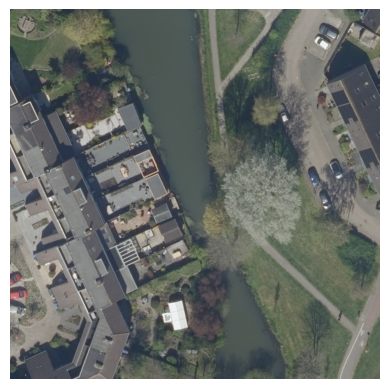

In [3]:
# remove-input
print(f"Size: {img.shape}")
print(f"Question (start): {question[:15]}")
print(f"Answer (start): {answer[:15]}")

_ = plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Tokenizer and Tokenization

As we can see, this Dataset uses a tokenizer to generate the Question out of a natural language text. If no tokenizer is provided, a default one will be used, however this may lead to bad performance if not accounted for. The tokenizer can be configured as input parameter.

In [4]:
# remove-output
from configilm.ConfigILM import _get_hf_model

tokenizer, _ = _get_hf_model("prajjwal1/bert-tiny")

ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer
)
img, question, answer = ds[0]

Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 335544.32it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.


:::{tip}
Usually this tokenizer is provided by the model itself as shown in the [VQA example](../vqa.ipynb) during dataset creation.
:::

During tokenization a sequence of tokens (integers) of specific length is generated. The length of this sequence can be set with the parameter `seq_length`. If the generated tokens are shorter than the sequence length, the sequence will be padded with zeros. If it is longer, the sequence is truncated.
:::{note}
Most tokenizer use an 'End of Sequence' token that will always be the last one in the non-padded sequence.
:::

In [5]:
# remove-output
ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=16
)
_, question1, _ = ds[0]
print(question1)

Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 321402.61it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.
[101, 2129, 2116, 10806, 3455, 5434, 2024, 3491, 1999, 2023, 3746, 1029, 102, 0, 0, 0]


In [6]:
# remove-input
print(question1)

[101, 2129, 2116, 10806, 3455, 5434, 2024, 3491, 1999, 2023, 3746, 1029, 102, 0, 0, 0]


In [7]:
# remove-output
ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    tokenizer=tokenizer,
    seq_length=8
)
_, question2, _ = ds[0]
print(question2)

Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 369542.20it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.
[101, 2129, 2116, 10806, 3455, 5434, 2024, 102]


In [8]:
# remove-input
print(question2)

[101, 2129, 2116, 10806, 3455, 5434, 2024, 102]


The tokenizer can also be used to reconstruct the input/question from the IDs including the special tokens:

In [9]:
print(f"Question 1: '{tokenizer.decode(question1)}'")
print(f"Question 2: '{tokenizer.decode(question2)}'")

Question 1: '[CLS] how many rectangular basketball courts are shown in this image? [SEP] [PAD] [PAD] [PAD]'
Question 2: '[CLS] how many rectangular basketball courts are [SEP]'


or without:

In [10]:
print(f"Question 1: '{tokenizer.decode(question1, skip_special_tokens=True)}'")
print(f"Question 2: '{tokenizer.decode(question2, skip_special_tokens=True)}'")

Question 1: 'how many rectangular basketball courts are shown in this image?'
Question 2: 'how many rectangular basketball courts are'


### Splits

It is possible to load only a specific split (`'train'`, `'val'`) in the dataset. The images loaded are specified using the csv files in the same folder as the LMDB file. By default (`None`), both are loaded into the same `Dataset`.

In [11]:
# remove-output
_ = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer
)

Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 320175.88it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.


### Restricting the number of loaded images

It is also possible to restrict the number of questions indexed. By setting `max_img_idx = n` only the first `n` images (in alphabetical order based on their S2-name) will be loaded. A `max_img_idx` of  `None`, `-1` or larger than the number of images in the csv file(s) (in this case 25) equals to load-all-images behaviour.

In [12]:
# hide-output
_ = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    max_img_idx=5,
    tokenizer=tokenizer
)

Counting Answers: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 124091.83it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.


### Select Number of Classes or specific Answers

For some applications, it is relevant to have only a certain number of classes as valid output. For example, the `RSVQAxBEN` DataSet could contain up to 2^19 > 0.5 million different classes. To prevent this dimension explosion, the number of classes can be limited. For the 'train' split, it is then automatically determined which combination of classes results in the highest reduction of the dataset.

In [13]:
# hide-output
train_ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    split="train",
    tokenizer=tokenizer,
    classes=3
)

Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 209715.20it/s]

The 3 most frequent answers cover about 50.00 % of the total answers.


These selected answers can be re-used in other splits or limited if only a subset is required.

:::{note}
The number of classes does not necessarily match the number of answers. If there are fewer answers then classes, the last classes will never be encoded in the one-hot encoded answer vector. If there are more, an `IndexError` will happen during accessing a non encode-able element.
:::

In [14]:
# remove-output
print(f"Train DS: {train_ds.selected_answers}")

ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.selected_answers
)
print(f"Val DS 1: {ds.selected_answers}")

ds = HRVQADataSet.HRVQADataSet(
    root_dir=my_data_path,  # path to dataset
    split="val",
    tokenizer=tokenizer,
    selected_answers=train_ds.selected_answers[:2],
)
print(f"Val DS 2: {ds.selected_answers}")

Train DS: ['highdensity', 'nonexistent', '0']
Val DS 1: ['highdensity', 'nonexistent', '0']
Val DS 2: ['highdensity', 'nonexistent']


In [15]:
# remove-input
print(f"Train DS: {train_ds.selected_answers}")
print(f"Val DS 1: {ds.selected_answers}")
print(f"Val DS 2: {ds.selected_answers}")

Train DS: ['highdensity', 'nonexistent', '0']
Val DS 1: ['highdensity', 'nonexistent']
Val DS 2: ['highdensity', 'nonexistent']


## HRVQADataModule

This class is a Lightning Data Module, that wraps the HRVQADataSet. It automatically generates DataLoader per split with augmentations, shuffling, etc., depending on the split. All images are resized and normalized and images in the train set additionally basic-augmented via noise and flipping/rotation. The train split is also shuffled, however this can be overwritten (see below).
To use a DataModule, the setup() function has to be called. This populates the Dataset splits inside the DataModule. Note, that there is no `Test` split with answers provided in this dataset and therefore cannot be used here.

In [23]:
# remove-output
from configilm.extra import HRVQA_DataModule
dm = HRVQA_DataModule.HRVQADataModule(
    data_dir=my_data_path  # path to dataset
)

Dataloader using 10 workers

HINT: pin_memory set to None 


In [24]:
print("Before:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

Before:
None
None
None


In [25]:
# remove-output
dm.setup(stage="fit")

(11:28:11) Datamodule setup called



Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 116185.71it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.

setup took 0.03 seconds
  Total training samples:       10  Total validation samples:       10


In [26]:
print("After:")
print(dm.train_ds)
print(dm.val_ds)
print(dm.test_ds)

After:
None


Afterwards the pytorch `DataLoader` can be easily accessed. Note, that $len(DL) = \lceil \frac{len(DS)}{batch\_size} \rceil$, therefore here with the default `batch_size` of 16: 25/16 -> 2.

In [27]:
train_loader = dm.train_dataloader()
print(len(train_loader))

1


The `DataModule` has in addition to the `DataLoader` settings a parameter each for `data_dir`, `image_size` and `max_img_idx` which are passed through to the `DataSet`.

### DataLoader settings

The `DataLoader` have four settable parameters: `batch_size`, `num_workers_dataloader`, `shuffle` and `pin_memory` with 16, `os.cpu_count()` / 2, `None` and `None` as their default values.

A shuffle of `None` means, that the train set is shuffled but validation and test are not.
Pinned Memory will be set if a `CUDA` device is found, otherwise it will be of. However, this behaviour can be overwritten with `pin_memory`. Changing some of these settings will be accompanied by a Message-Hint printed.

In [29]:
# remove-output
dm = HRVQA_DataModule.HRVQADataModule(
    data_dir=my_data_path,  # path to dataset
    batch_size=4,
    tokenizer=tokenizer
)
dm.setup(stage="fit")

Dataloader using 10 workers

HINT: pin_memory set to None 
(11:28:31) Datamodule setup called


Counting Answers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 229196.94it/s]


The 1000 most frequent answers cover about 100.00 % of the total answers.
setup took 0.00 seconds
  Total training samples:       10  Total validation samples:       10


In [30]:
print(len(dm.train_dataloader()))

3


In [ ]:
# hide-output
_ = HRVQA_DataModule.HRVQADataModule(
    data_dir=my_data_path,  # path to dataset
    shuffle=False
)

In [ ]:
# hide-output
_ = HRVQA_DataModule.HRVQADataModule(
    data_dir=my_data_path,  # path to dataset
    num_workers_dataloader=2
)

In [ ]:
# hide-output
_ = HRVQA_DataModule.HRVQADataModule(
    data_dir=my_data_path,  # path to dataset
    pin_memory=False
)